## Quantification of antibody nativeness using LSTM network

As a final task, a Long Short-Term Memory network was used to quantify the nativeness of given sequences. The architecture is described in this [paper](https://academic.oup.com/peds/article/32/7/347/5554642?login=false), and the code was downloaded from this [GitHub repository](https://github.com/vkola-lab/peds2019).

The underlying assumption is that, given an input sequence, a well-trained model would be able to predict any residue by learning information from its neighbors. The output of the model is the averaged sum of negative logarithms of all conditional probabilities (see paper); thus, lower scores indicate a higher degree of nativeness.

The model takes files containing sequences in plain text format, delimited by one line-break.

In [23]:
import sys
# add path to the folder containing the LSTM model
sys.path.append('/home/enrico/Desktop/lecture_notes/erasmus/bioinformatics/project/peds2019')

In [25]:
from ablstm import ModelLSTM
from Bio import SeqIO
import anarci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [39]:
# parse sequenced aligned with ANARCI numbering

human_seq = [seq.seq for seq in SeqIO.parse("data/alignments/human_hmm_align.fasta", "fasta")]
mouse_seq = [seq.seq for seq in SeqIO.parse("data/alignments/mouse_hmm_align.fasta", "fasta")]

In [4]:
# split the sequences in the following way: 60% train set, 20% validation set, 20% test set

idx_val = round(len(human_seq)*0.6)      # find indices for train/val/test split
idx_test = round(len(human_seq)*0.8)     # 

In [7]:
lstmDir = 'data/lstm_model/'

In [8]:
# prepare input files in plain text format for the LSTM model (only sequences)

with open(f'{lstmDir}human_seq_train.txt', 'w') as f:
    for seq in human_seq[:idx_val]:
        f.write(f'{seq}\n')

with open(f'{lstmDir}human_seq_val.txt', 'w') as f:
    for seq in human_seq[idx_val:idx_test]:
        f.write(f'{seq}\n')

with open(f'{lstmDir}human_seq_test.txt', 'w') as f:
        for seq in human_seq[idx_test:]:
            f.write(f'{seq}\n')


# use the same amount of mouse sequences as evaluation set
with open(f'{lstmDir}/mouse_seq.txt', 'w') as f:
    for seq in mouse_seq[idx_test:]:
        f.write(f'{seq}\n')

In [9]:
# define the LSMT model

""" model = ModelLSTM(
    embedding_dim=128,      # embedding layer dimensions
    hidden_dim=128,         # hidden layer dimension
    device='cuda',          # select GPU as device
    gapped=True,            # gapped=True since the sequences contain gaps "-"
    fixed_len=True          # since all the sequences alignmned with ANARCI has same lenght
) """

In [10]:
# define input paths for train and valdiation datasets and fit the model

trn_fn = f'{lstmDir}human_seq_train.txt'
vld_fn = f'{lstmDir}human_seq_val.txt'

# model.fit(trn_fn=trn_fn, vld_fn=vld_fn, n_epoch=20, save_fp=None)
# model.save(fn=f'{lstmDir}model.npy')

          (VLD): 100%|| 2000/2000 [00:00<00:00, 2328.56seq/s, loss=0.280272, acc=0.940169]


In [15]:
# load model
model_loaded = ModelLSTM(
    embedding_dim=128,      # embedding layer dimensions
    hidden_dim=128,         # hidden layer dimension
    device='cuda',          # select GPU as device
    gapped=True,            # gapped=True since the sequences contain gaps "-"
    fixed_len=True          # since all the sequences aligned with ANARCI have same lenght
)
model_loaded.load(fn='data/lstm_model/model.npy')

In [16]:
tst_fn = f'{lstmDir}human_seq_test.txt'       # define input path for human test set
tst_fn_mouse = f'{lstmDir}mouse_seq.txt'      # define input path for mouse dataset

human_score = model_loaded.eval(fn=tst_fn)               # generate predictions
mouse_score = model_loaded.eval(fn=tst_fn_mouse)         #

100%|| 1999/1999 [00:00<00:00, 2713.15seq/s]


In [56]:
# print score of bevacizumab etc

abSeq = [(seq.id, seq.seq) for seq in SeqIO.parse('data/alignments/nTopSequences.fasta', 'fasta')]

with open(f'{lstmDir}comm_ab.txt', 'w') as f:
    for seq in abSeq:
        f.write(f'{seq[1]}\n')    

comm_ab = lstmDir + 'comm_ab.txt'
comm_ab_score = model_loaded.eval(fn=comm_ab)

for i in range(len(abSeq)):
    print(f'{abSeq[i][0]} has score: {comm_ab_score[i]:.5f}')

100%|| 3/3 [00:00<00:00, 206.26seq/s]

Bevacizumab has score: 1.50118
Caplacizumab has score: 1.71924
muromonab has score: 1.83387


In [17]:
print(human_score)
print(mouse_score)

[0.41881922 0.21037962 0.08248673 ... 0.17867185 0.890353   0.87392783]
[1.4842085 1.4447832 2.0738158 ... 1.8228635 2.136198  1.8379416]


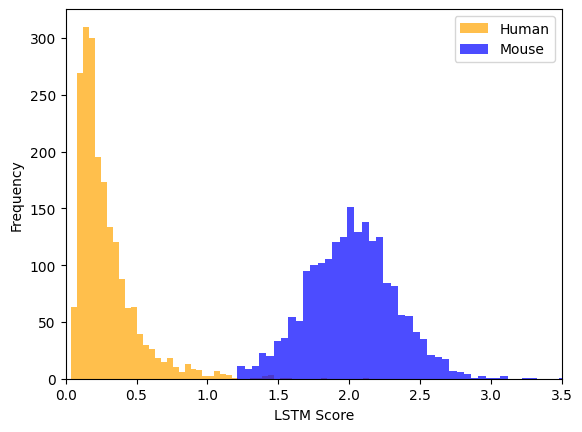

In [26]:
# plot score frequences
plt.figure()
plt.xlabel('LSTM Score')

ax1 = pd.Series(human_score).plot(kind = 'hist', bins=50, color = 'orange', alpha = 0.7, label = 'Human')
ax2 = pd.Series(mouse_score).plot(kind = 'hist', bins=50, color = 'blue', alpha = 0.7, label = 'Mouse')

plt.xlim([0, 3.5])

ax1.legend()
ax2.legend()

plt.savefig('data/lstm_model/score_plot.png', bbox_inches="tight", pad_inches = 0.08)
plt.show()

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_ROC(h_scores, m_scores):

    h_scores = pd.DataFrame(h_scores, columns=['scores'])
    h_scores['true'] = 1
    m_scores = pd.DataFrame(m_scores, columns=['scores'])
    m_scores['true'] = 0

    data = pd.concat([h_scores, m_scores], ignore_index=True)
    # scores need to be normalized since we selected 1 (positive class) for human 
    # but mouse sequences have a higher score
    data['scores'] = (data['scores'] - data['scores'].min()) / (data['scores'].max() - data['scores'].min())
    data['scores'] = 1 - data['scores']
    fpr, tpr, thresholds = roc_curve(data['true'], data['scores'], pos_label=1)
    auc = roc_auc_score(data['true'], data['scores'])

    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend([f'AUC:{auc:.5f}'])
    plt.savefig('data/lstm_model/ROC.png', bbox_inches="tight", pad_inches = 0.08)
    plt.show()

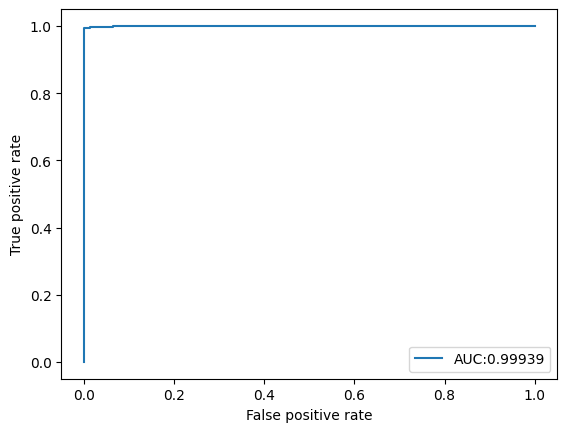

In [48]:
plot_ROC(human_score, mouse_score)

### Plot lstm score vs human germline identity

As human germline identity, the v_identity score in the ANARCI numbering was used. To obtain such score for mouse sequences, the numbering of mouse sequences was repeated forcing ANARCI to use a human germline.

Code is messy, but there is no point in cleaning it since we only need the plots.

In [27]:
# run anarci on mouse sequences setting human as germline to retrieve the v_gene identity
# note that this output is not used to extract any alignment

mouseSeqPath = 'data/mouse.fa'

results = anarci.run_anarci(mouseSeqPath,
    ncpu=8,
    scheme='imgt',
    assign_germline=True,
    allowed_species=['human'],
    output=True,
    csv=True,
    outfile='data/mouse_vs_human_germ'
)

In [34]:
def extract_score_vs_identity(numberingPath, fastaPath, scores, idx_test, organism):

    # retrieve numbering csv that has a columns named 'v_identity'
    numbering = pd.read_csv(numberingPath)
    numbering = numbering[['Id', 'v_identity']]       # keep only Id and v_identity columns

    # retrieve Ids from the fasta alignment obtained from the same numbering csv, this fasta was used as input for the LSTM model
    ids = pd.Series([int(seq.id) for seq in SeqIO.parse(fastaPath, "fasta")], name = 'Id')

    # the output sequences were only the ones belonging to the test set, so from idx_test to the end
    ids = ids[idx_test:]

    # merge series of Ids of scored sequences and df containing Id and v_identity
    ret = pd.merge(ids, numbering, how='left', on='Id')
    ret['score'] = scores
    ret['organism'] = organism

    return ret

In [35]:
humanDf = extract_score_vs_identity('data/human_numbering_H.csv', 'data/alignments/human_hmm_align.fasta', human_score, idx_test, 'human')
mouseDf = extract_score_vs_identity('data/mouse_vs_human_germ_H.csv', 'data/alignments/mouse_hmm_align.fasta', mouse_score, idx_test, 'mouse')

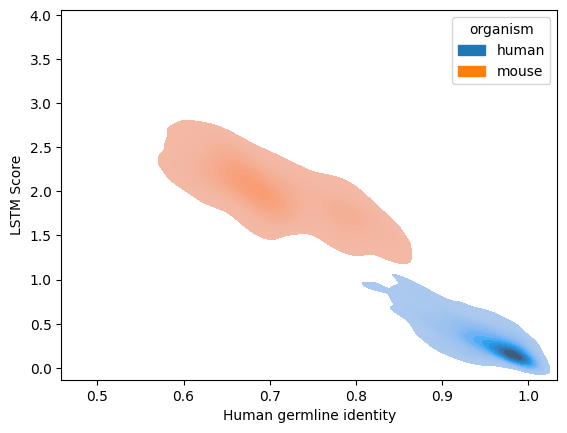

In [40]:
mergeDf = pd.concat([humanDf, mouseDf])
kdeplot = sns.kdeplot(data=mergeDf, x='v_identity', y='score',
            fill=True, levels=20, hue='organism')

kdeplot.set(xlabel = 'Human germline identity', ylabel = 'LSTM Score')
plot_fig = kdeplot.get_figure()
plot_fig.savefig('data/lstm_model/score_vs_identity.png', bbox_inches="tight", pad_inches = 0.08)